## 7.1. Voting Classifier

* Ensemble : 다수의 predictor의 예측값을 수집하여 예측하는 방법
* Random Forest : 다수의 Decision Tree의 예측값 중 최빈값을 예측값으로 결정하는 학습방법

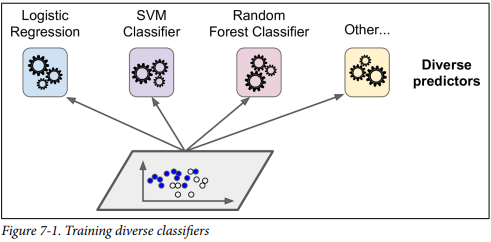

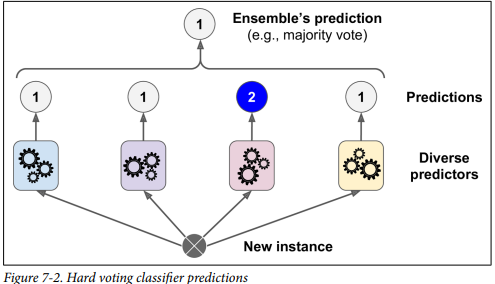

* hard voting : predictor의 예측값 중 최빈값을 예측값으로 결정하는 방법. 각 predictor가 weak learner일지라도 그 수가 충분히 많고 다양하다면 ensemble은 하나의 strong learner 대비 높은 성능을 보일 수 있다.


* Law of Large Numbers : Ensemble의 원리는 대수의 법칙에 기인한다. 51%의 정확도를 가진, 즉 random prediction보다  조금 나은 weak learner 1000개로 ensemble model을 만든다고 가정해보자. 이 때 최빈값을 예측값으로 삼는다면 75%의 정확도를 기대할 수 있다. 그러나 이는 predictor가 서로 독립적이고 오차항의 multicollinearity가 없다는 가정하에 가능한 이야기다. 그러나 이 경우엔 동일 데이터를 기반으로 훈련되기 때문에 이러한 가정이 성립하지 않는다.

In [68]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=10000, noise=.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [62]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8605
RandomForestClassifier 0.939
SVC 0.9435
VotingClassifier 0.9435


* 만일 확률기반 class predictor만으로 구성된 voting classifier가 존재한다면, voting='soft'를 통해 soft voting을 구현할 수 있다. 이는 개별 predictor 예측의 평균값을 통해 확률이 가장 높은 클래스를 예측하게 된다.

In [41]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8735
RandomForestClassifier 0.942
SVC 0.9455
VotingClassifier 0.94


## 7.2. bagging & pasting

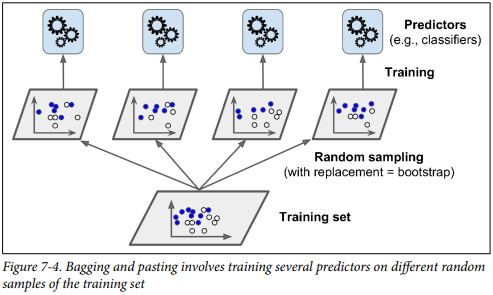

* 다양한 predictor를 만들기 위해선 각기 다른 알고리즘을 사용하면 된다.
* 그러나 같은 알고리즘을 사용하되, training subset을 구성하여 predictor를 각기 다르게 학습시키는 것 또한 가능하다. training set에서 중복을 허용하여 sampling하는 방식을 bagging(bootstrap aggregating)이라 부르며, 중복을 허용하지 않은 sampling을 pasting이라 한다.


* 이 때 classification 문제라면 최빈값을 ensemble의 예측결과로 활용하고, regression 문제라면 그 평균을 사용한다.
* 개별 predictor는 subset으로 학습되어있기 때문에 bias가 강하지만 aggregation 단계에서 bias와 variance가 감소한다. 통상적으로 ensemble model의 결과는 하나의 predictor를 모든 training set으로 학습시켰을 때보다 bias는 비슷하나 variance는 줄어드는 경향이 있다.
* figure 7-4에서 볼수 있듯이 predictor는 동시에 다른 CPU core로 병렬학습이 가능하다. 

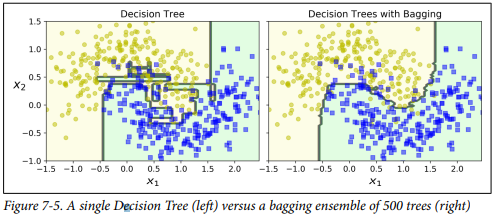

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

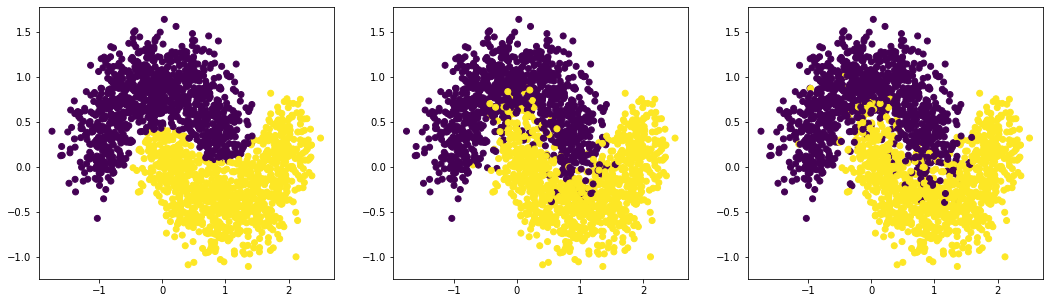

In [57]:
import matplotlib.pyplot as plt

indv = DecisionTreeClassifier()
indv.fit(X_train, y_train)
y_indv = indv.predict(X_test)

fig, ax = plt.subplots(1,3, figsize=(18,5))
ax[0].scatter(X_test.T[0], X_test.T[1], c=y_pred)
ax[1].scatter(X_test.T[0], X_test.T[1], c=y_test)
ax[2].scatter(X_test.T[0], X_test.T[1], c=y_indv)

* n_estimator로 predictor수를 설정하고, bootstrap으로 bagging vs. pasting을 설정해준다. 마지막으로 n_jobs로 사용할 CPU core수를 지정해주면 된다. 
* 위 그림에서 볼 수 있듯이 bagging을 활용한 예측이 더욱 일반화가 잘되어있음을 확인할 수 있다.

* bagging을 사용할 경우 특정 instance는 bootstrap으로 여러번 sampling되고 특정 instance는 전혀 선택되지 않을 수도 있다. 이는 평균적으로 predictor에 전체 trainingset 중 63%만 sampling됨을 뜻한다. 이외의 37% sample을 OOB(out of bag) sample이라 부른다. 

In [58]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.935875

In [59]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.938

In [60]:
bag_clf.oob_decision_function_

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.93785311, 0.06214689]])

## 7.3. Random Patch & Random Subspaces

* BaggingClassifier는 feature sampling 또한 가능하다. 이는 high dimensional dataset을 다룰 떄 유용하다. 
* Random Patch : feature & instance를 모두 sampling하는 방식
* Random Subspaces : instance를 모두 사용(bootstrap=False, max_samples=1.)하고, feature는 sampling(bootstrap_features=True, max_features <=1.)하는 방식


* Feature Sampling은 predictor의 다양성을 높이며 bias는 늘어나지만 variance는 더욱 낮아진다.

## 7.4. Random Forest

* RF는 bagging/pasting을 적용한 decision tree ensemble 기법이다.
* RF는 전체 feature 중 최적의 feature를 찾는 대신, 랜덤하게 선택한 feature 후보군 중 최적의 특성을 찾는 식이다.
* 이는 decision tree의 다양성을 높이기에 bias가 커질수 있으나 전체적인 variance는 낮아지기에 좋은 모델이 형성된다.
* 극도로 랜덤하게 feature 후보군을 선택하는 RF를 extra-trees(extremely randomized trees)라 부른다. 일반적인 RF보다도 더 빠르다.

In [63]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [65]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=12),
    n_estimators=500, max_samples=1., bootstrap=True, n_jobs=-1)

In [67]:
from sklearn.datasets import load_iris, fetch_openml
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0962351881032652
sepal width (cm) 0.023836855442547572
petal length (cm) 0.421183967828312
petal width (cm) 0.45874398862587523


In [80]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']
y = y.astype(int)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)


KeyboardInterrupt



<AxesSubplot:>

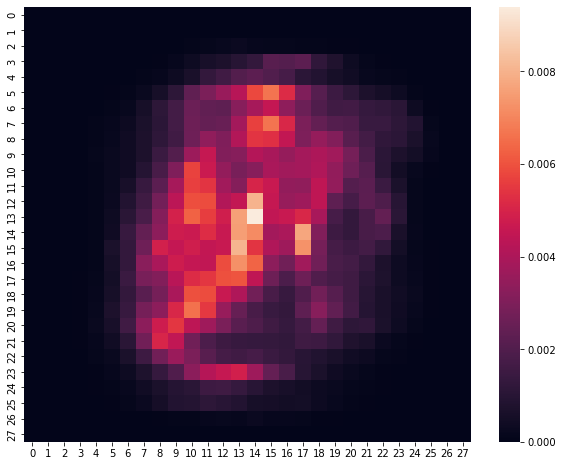

In [89]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(rnd_clf.feature_importances_.reshape(28,28), fmt=(20,20))

## 7.5. Boosting

* boosting은 weak learner를 연결하여 strong learner를 만드는 ensemble 기법의 일종이다. 

- AdaBoost(adaptive boosting): 이전 predictor가 underfitting한 sample에 대한 가중치를 높이면 학습이 어려운 feature에 대해 더 많이 학습하게 된다. 
- gradient boosting: 

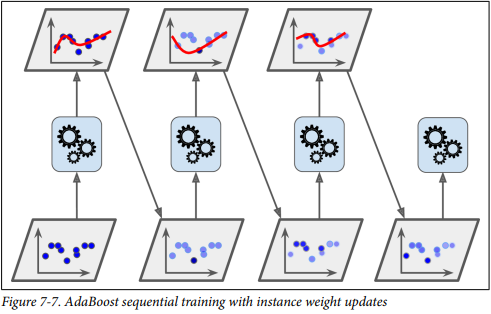

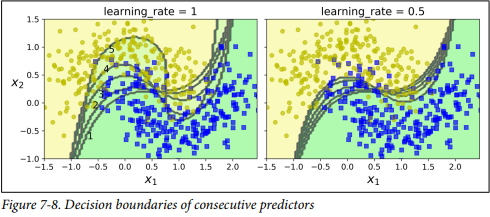

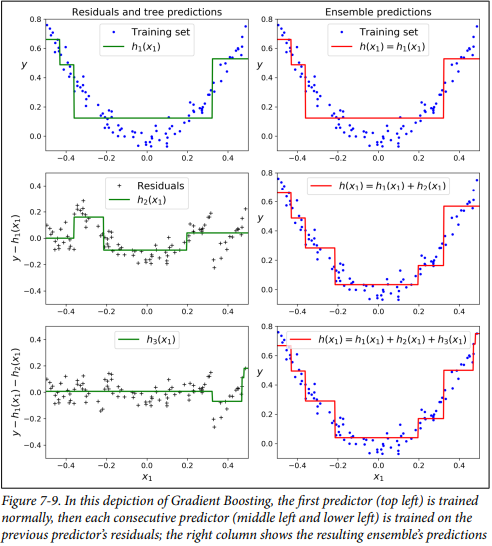

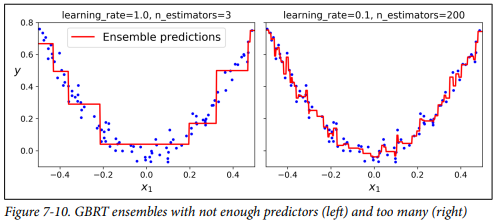

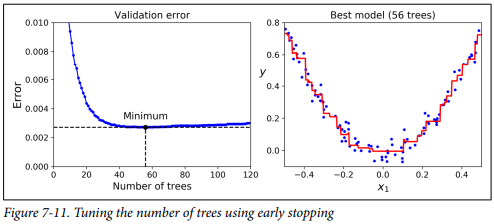

## 7.6. Stacking

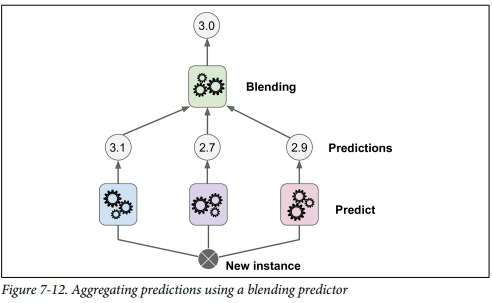

* hard voting과 같은 간단한 방식으로 각 predictor의 결과를 취합하는 대신, 취합하는 함수를 학습시키는 방식의 ensemble
* 이 때 최종 예측기를 blender라 부르며 hold-out set를 활용하여 blender를 학습시킨다. 학습방법은 아래와 같다.

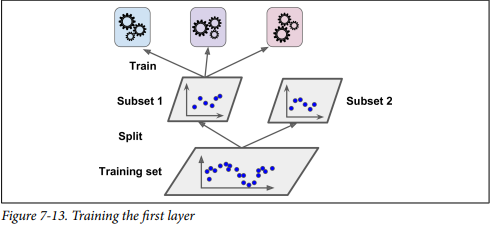

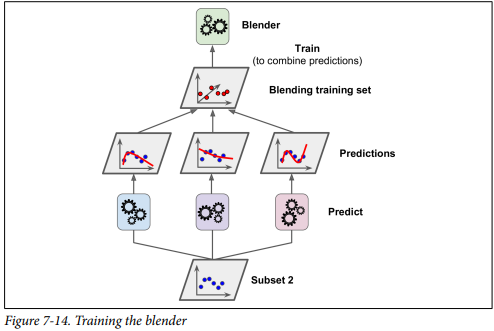

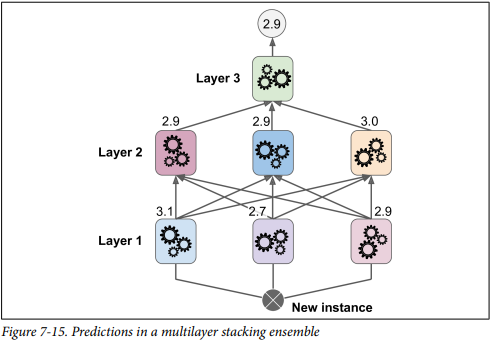

1. training set을 subset 2개로 분류한다.
2. subset1을 첫번째 레이어 학습에 활용한다.
3. 학습된 레이어의 예측기가 subset2에 대한 예측을 만든다.
4. subset2에 대한 예측을 blender 학습에 활용하여 최종값을 산출한다.